<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#План-работ:" data-toc-modified-id="План-работ:-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>План работ:</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Нам необходимо выполнить исследовние для компании«Чётенькое такси», которая собрала исторические данные о заказах такси в аэропортах. 

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Для этого построим модель предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План работ:
1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами (тестовая выборка размером 10% от исходных данных).
4. Проверим данные на тестовой выборке.


Количество заказов находится в столбце `num_orders` 

## Подготовка

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (TimeSeriesSplit, 
                                     cross_val_score, 
                                     StratifiedKFold, 
                                     GridSearchCV,
                                     RandomizedSearchCV, 
                                     cross_validate, 
                                     KFold,
                                     train_test_split)
                                     
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (make_scorer, 
                             mean_squared_error)

from statsmodels.tsa.seasonal import seasonal_decompose

from numpy.random import RandomState

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [13]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [14]:
df.sample(5)

,num_orders
datetime,
2018-06-14 04:00:00,14
2018-03-11 22:40:00,19
2018-06-26 04:00:00,12
2018-03-23 23:50:00,8
2018-06-17 13:30:00,5


In [15]:
print("Данные находятся в диапазоне от", df.index.min(), "до", df.index.max())

Данные находятся в диапазоне от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


In [16]:
#проверим, в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)

True


## Анализ

In [17]:
month = df.resample('1M').sum()
week = df.resample('1W').sum()
hour = df.resample('1H').sum()

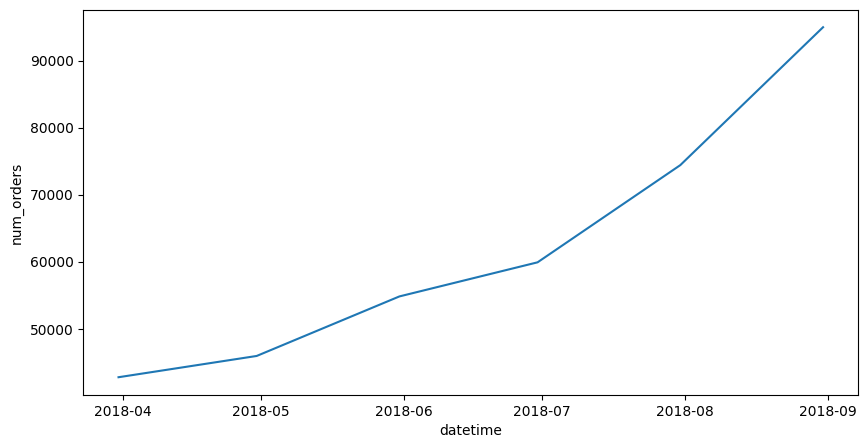

In [18]:
sns.lineplot(x=month.index,y=month['num_orders']);

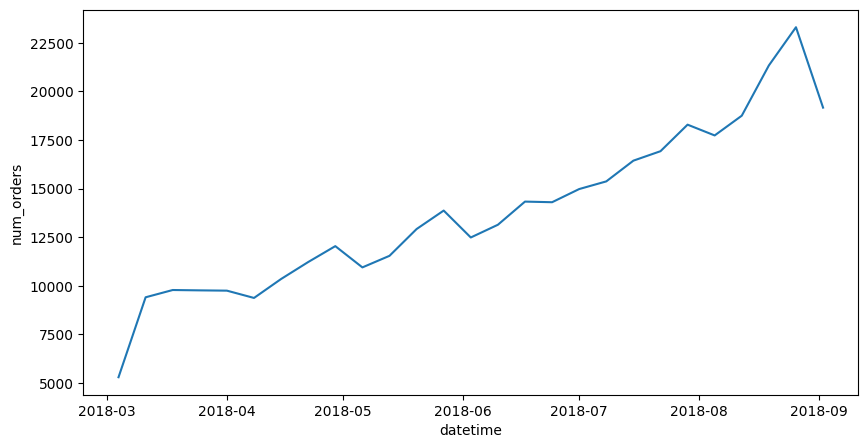

In [19]:
sns.lineplot(x=week.index,y=week['num_orders']);

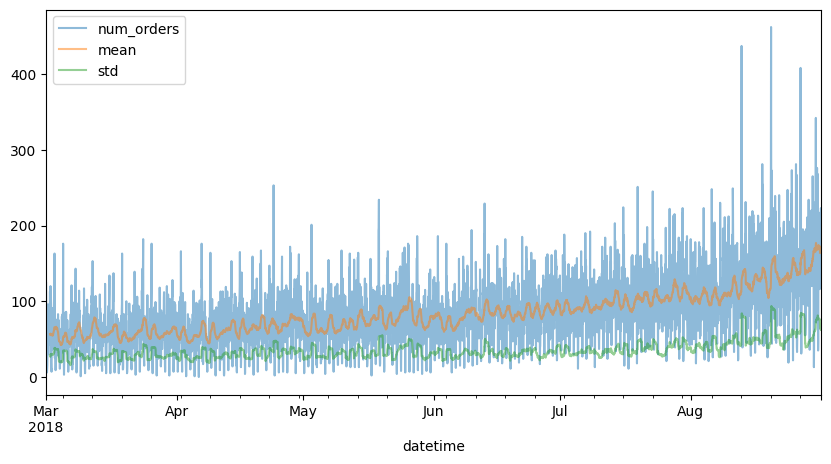

In [20]:
hour['mean'] = hour['num_orders'].rolling(24).mean()
hour['std'] = hour['num_orders'].rolling(24).std()
hour.plot(alpha=0.5);

In [21]:
#Сделаем копию датасета чтобы провести анализ
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
# df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
# df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

In [22]:
decomposed_df = seasonal_decompose(df_copy['num_orders'])

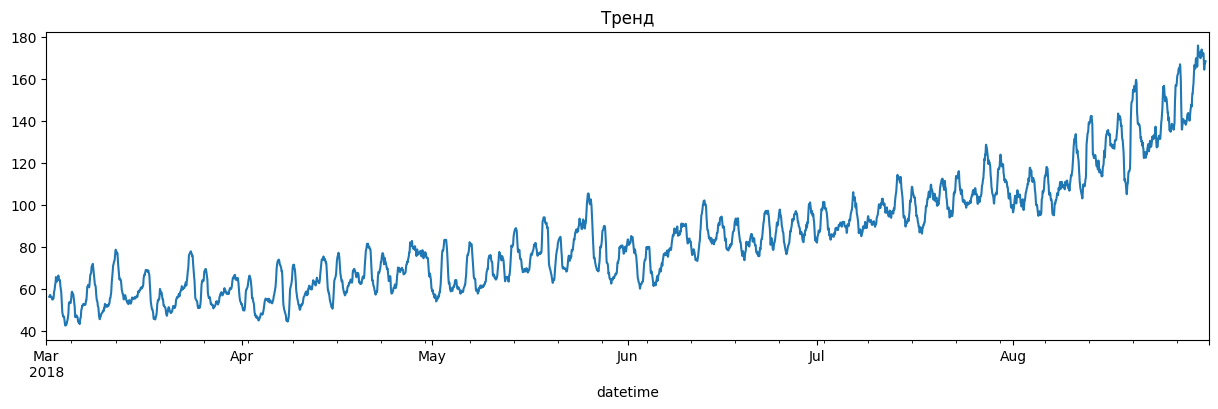

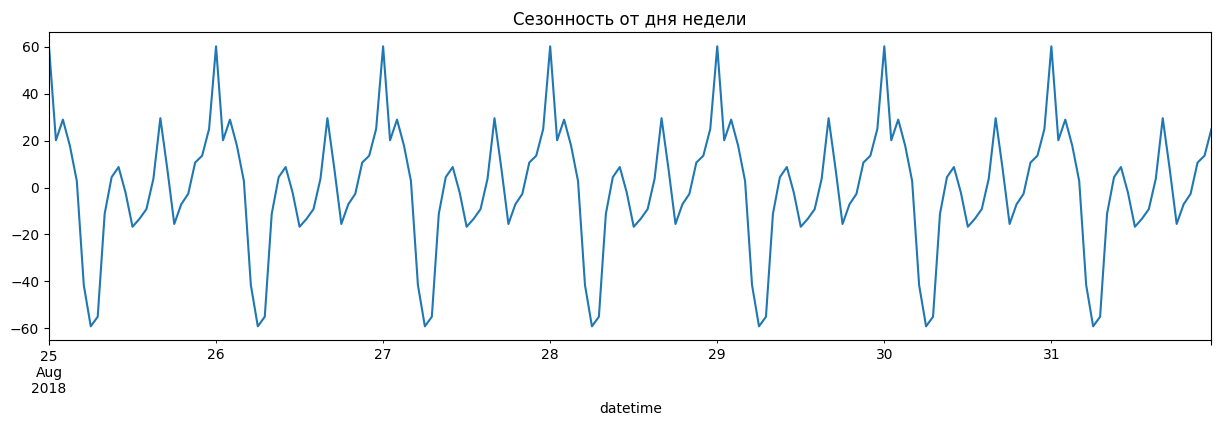

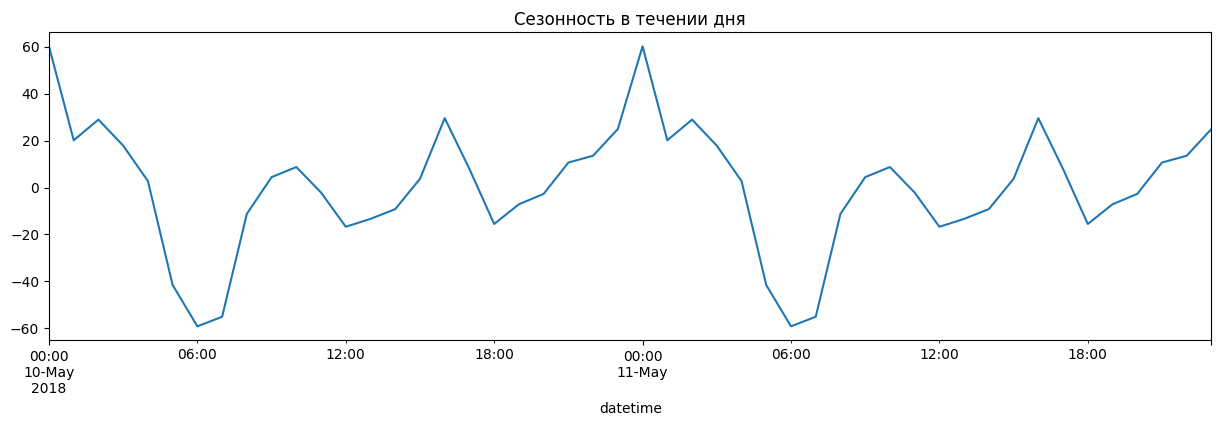

In [23]:
decomposed_df.trend.plot(title='Тренд', figsize=(15,4))
plt.figure(figsize=(15, 4))
decomposed_df.seasonal.tail(24*7).plot(title='Сезонность от дня недели', figsize=(15,4))
plt.figure(figsize=(15, 4))
decomposed_df.seasonal['2018-05-10':'2018-05-11'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня');

***Тренд*** - можем наблюдать ***постепенное увеличение заказов***

***Сезонность от дня недели*** - можем наблюдать провалы в графике - вероятнее всего это ***спад количества заказов в выходные дни***

***Сезонность от времени суток*** - можем видеть спад количества заказов в ***ночное-утреннее время***

## Обучение

In [24]:
#выполним ресемплирование по одному часу
df = df.resample('1H').sum()

In [25]:
def make_features(df, max_lag, rolling_mean_size):
    df['day_of_week'] = df.index.dayofweek #вероятнее всего существует сезонность от дня недели
    df['1H'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
make_features(df, 9, 9)
df.head()

,num_orders,day_of_week,1H,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#Разделим нашу таблилцу на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [28]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [29]:
state = RandomState(12345)

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', "Подберем модели")
])

params = [
    {
        'model': [RandomForestRegressor(random_state=state)],
        'model__n_estimators': [20, 30],
        'model__max_features': np.linspace(0.1, 1, 10)
    }, {
        'model': [LinearRegression()]
    }, {
        'model': [Lasso(random_state=state)],
        'model__alpha': np.logspace(-3, 1, 10)
    }
]

In [30]:
score='neg_root_mean_squared_error'
tscv = TimeSeriesSplit(n_splits=9) 
model = GridSearchCV(pipe, param_grid=params, cv = tscv, n_jobs = -1, verbose=False, scoring=score, return_train_score=True)

In [31]:
model.fit(X, y)

/Users/andrew/Documents/Python_projects/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e+05, tolerance: 4.642e+02
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', 'Подберем модели')]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_features=0.9,
                                                          n_estimators=30,
                                                          random_state=RandomState(MT19937) at 0x17A7C4F40)],
                          'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0...
                          'model__n_estimators': [20, 30]},
                         {'model': [LinearRegression()]},
                         {'model': [Lasso(random_state=RandomState(MT19937) at 0x17A7C4F40)],
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=False)

In [32]:
print('Лучшие параметры GridSearch:', model.best_params_)
print('Лучший RMSE:', -model.best_score_)

Лучшие параметры GridSearch: {'model': RandomForestRegressor(max_features=0.9, n_estimators=30,
                      random_state=RandomState(MT19937) at 0x17A7C4F40), 'model__max_features': 0.9, 'model__n_estimators': 30}
Лучший RMSE: 24.561638396278784


## Тестирование

In [34]:
predictions = model.best_estimator_.predict(X_test)

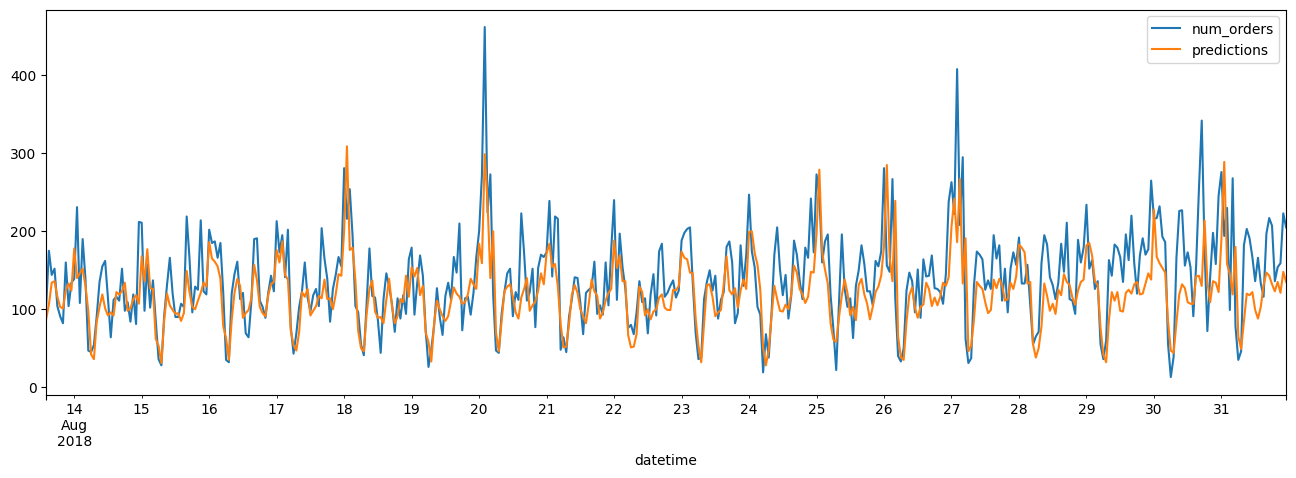

In [36]:
#построим график по предсказаниям и исходным данных
graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out.plot(figsize=(16,5));

Как видно на графике, наша модель RandomForestRegressor достаточно неплохо предсказала количесвто заказов такси. 

In [37]:
print('RMSE on Test:', np.sqrt(((predictions - y_test) ** 2).mean()) ) 


RMSE on Test: 46.98465804926149


### Выводы:

Мы проанализировали исходные данные временного ряда в различных декомпозициях, построили графики тренда, сезонности по дням недели и времени суток. 
Заметили, что по количеству заказов наблюдается положительная динамика. 
Увидели закономерности в распределении заказов от времени суток и дням недели: в ночное время и в выходные количество заказов значитено меньше. 

Мы проанализировали несколько можелей с применением GridsearchCV, также учли особенности работы с временными рядами через TimeSeriesSplit и отобрали лучшую модель по метрике RMSE. 

Наилучшие результаты показала модель RandomForestRegressor с показателем RMSE - 24.56

Визуализировали полученные предсказания временного ряда и убедились в качетсве прогноза. 